In [1]:
from collections import defaultdict
from datetime import datetime
import dill
from itertools import permutations, combinations
import json
from operator import itemgetter
import os
import pickle
import random
import re
import time

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
sns.set(style='ticks', font_scale=1.2)
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import little_mallet_wrapper as lmw

In [2]:
data_directory_path   = '/Users/maria/Documents/data/birth-control'
output_directory_path = '/Users/maria/Documents/output/birth-control'
topics_directory_path = '/Users/maria/Documents/output/birth-control/topics-by-leann/revision-final'

<br><br><br><br>

# **Load topics**

In [3]:
source_topic_keys_dict = {}
source_distributions_dict = {}
source_training_dict = {}

for _source in ['reddit', 'twitter', 'webmd']:

    source_topic_keys_dict[_source] = [_line.split('\t')[2].split()[:10] for _line in open(topics_directory_path + '/' + _source + '/mallet.topic_keys.35', 'r') if _line.strip()]
    source_distributions_dict[_source] = [_line.split('\t')[2:] for _line in open(topics_directory_path + '/' + _source + '/mallet.topic_distributions.35', 'r') if _line.strip()]
    source_training_dict[_source] = [' '.join(_line.split()[2:]) for _line in open(topics_directory_path + '/' + _source + '/training.txt', 'r') if _line.strip()]

len(source_topic_keys_dict['reddit']), len(source_distributions_dict['reddit']), len(source_training_dict['reddit']), len(source_distributions_dict['twitter']), len(source_training_dict['twitter']), len(source_distributions_dict['webmd']), len(source_training_dict['webmd'])

(35, 48000, 48000, 48000, 48000, 2640, 2640)

In [63]:
reddit_strings = """

                pregnancy tests, symptoms & pregnancy, test, pregnant, negative, period \\
        missed pills, unprotected sex & pill, sex, day, took, last \\
        
        questions about condom-use, pregnancy concerns & condoms, sex, pregnant, condom, pregnancy \\
        informative outlinks, efficacy & www, antibiotics, pill, effectiveness, reddit \\
        
        infections & infection, yeast, infections, iud, antibiotics \\
        acne, skin and hair concerns & acne, hair, skin, loss, face \\
        
        iud, hormonal vs. copper & iud, mirena, copper, hormonal, hormones \\
        starting new packs, skipping pills & pills, week, pill, pack, placebo \\
        
        nausea, upset stomach & day, feel, nausea, night, feeling \\
        implant experience, advice-seeking & know, anyone, thanks, implant, getting \\
        
        implant irregular bleeding, spotting & bleeding, nexplanon, stop, irregular, months \\
        costs, insurance, planned parenthood & insurance, planned, parenthood, health, pay \\
        
        weight gain, losing weight & weight, gain, gained, pounds, lost \\
        bleeding, spotting, discharge & blood, bleeding, period, spotting, discharge \\
        
        pain cramping, cysts & pain, cramps, anyone, else, cysts \\
        iud string concerns & iud, strings, feel, cervix, check \\
        
        discussion of side effects & side, effects, effect, nexplanon, implant \\
        anxiety,depression, mood swings & feel, anxiety, mood, depression, time \\
        
        considering new methods & pill, pills, taking, hormonal, take \\
        menstrual products & cup, menstrual, iud, using, tampons \\
        
        missing pills, effectiveness & pill, take, time, taking, day \\
        hormone dosages & pill, estrogen, dose, pills, progestin \\
        
        doctor appointments, interactions & doctor, said, told, appointment, went \\
        switching pills, generics & pill, taking, tri, switched, generic \\
        
        blood clots, migraines, risk of stroke & pill, migraines, blood, risk, estrogen \\
        experience-sharing, rebutting negative stories & experience, stories, people, experiences, read \\
        
        iud insertion experience & pain, insertion, iud, cramps, felt \\
        changes in period, spotting & period, days, since, month, started \\
        
        implant insertion experience & arm, implant, nexplanon, feel, insertion \\
        implant removal & nexplanon, implant, years, removed, months \\
        
        method efficacy & effective, women, implant, nexplanon, years \\
        changes in sex drive & sex, drive, libido, want, feel \\
        
        ovulation & ovulation, cycle, ovulate, fertility, days \\
        recommending to talk with doctor & doctor, think, body, good, know \\
        
        heavy, light period, spotting, time periods & period, periods, months, days, first \\

                 """

twitter_strings = """

                        implant experiences & arm, nexplanon, implant, implanon, rod \\
        iud insertion experiences & iud, pain, insertion, uterus, doctor \\
        
        iud discourse and humor & iud, thanks, baby, day, today \\
        iud viral stories & baby, iud, born, fingers, tiny \\
        
        male contraception development & pill, contraceptive, male, men, scientists \\
        experience-sharing & nexplanon, implanon, implant, best, arm \\
        
        informative news stories & iud, women, iuds, contraception, long \\
        pill viral quotes & pill, pregnancy, best, thing, put \\
        
        iud political news & iud, abortion, anti, must, healthcare \\
        iud viral stories  & implant, contraceptive, school, girl, without \\
        
        costs, insurance, planned parenthood & iud, insurance, free, planned, health \\
        pill viral tweets & pill, take, implant, taking, time \\
        
        pill informative news & pill, male, bit, new, men \\
        iud misc tweets & iud, god, thank, bless, house \\
        
        weight gain, loss & weight, gain, nexplanon, gained, implanon \\
        FDA news, Woody Allen quote & oral, contraceptive, contraception, fda, new \\
        
        iud discourse, humor & iud, looks, ied, sex, make \\
        contraceptive studies & contraceptive, risk, oral, pill, cancer \\
        
        contraception misinformation & pill, contraceptive, women, oral, first \\
        FDA announcements & implant, fda, essure, safety, review \\
        
        pill viral quote & pill, men, male, take, makes \\
        upcoming iud procedure & iud, getting, nexplanon, today, appointment \\
        
        pill news & pill, dies, djerassi, father, carl \\
        iud viral tweets & iud, know, tubes, need, pregnant \\
        
        changes in periods, cramps & iud, nexplanon, period, periods, cramps \\
        adverse side effects & side, effects, pill, effect, contraceptive \\
        
        misc tweets & years, effective, iud, rate, implanon \\
        humor & iud, implanon, nexplanon, lol, shit \\
        
        iud informative tweets & iud, copper, device, intrauterine, hormone \\
        implant complications & implant, contraceptive, essure, bayer, remote \\
        
        abortion, contraception, political discourse & pill, iud, women, abortion, contraceptive \\
        LARC recommendations, advice & iud, nexplanon, one, know, people \\
        
        changes in period, implant & years, nexplanon, period, months, year \\
        emergency contraception & contraceptive, pill, oral, pills, contraception \\
        
        LARC discourse, news  & iud, implanon, question, bit, post \\

                  """

webmd_strings = """

                rebutting negative reviews  & reviews, read, reading, experience, people \\
        
        pregnancy-prevention & medication, pregnancy, preventing, effective, medications \\
        blood clots, blood pressure, stroke, migraines & blood, pressure, high, yeast, infection \\
        
        implant insertion/removal experience & implant, arm, nexplanon, shot, depo \\
        changes in sex drive & sex, drive, low, husband, zero \\
        
        positive experiences & take, love, little, everyday, thing \\
        acne and skin concerns & acne, face, skin, never, cystic \\
        
        irregular periods, bleeding, highly recommended & periods, recommend, years, product, long \\
        anxiety, depression, panic attacks, mood swings & anxiety, nexplanon, depression, implant, began \\
        
        leg, back pain, stomach aches & pain, pains, back, stomach, legs \\
        anxiety, depression, mood swings, fatigue, weight gain & mood, swings, weight, depression, gain \\
        
        years, months, duration of use & years, year, almost, old, one \\
        switching pills, generic & switched, generic, pharmacy, years, ortho \\
        
        iud, ovarian cysts, surgery & pain, mirena, removed, iud, painful \\
        heavy bleeding, spotting & heavy, tampons, wear, needed, pads \\
        
        pill acne, headaches, breast pain, cramps & pill, taking, noticed, acne, breast \\
        risk-benefit analysis & cannot, low, dose, gyn, device \\
        
        iud insertion experience & pain, insertion, cramping, iud, inserted \\
        experience-sharing & months, recommend, form, different, taking \\
        
        life interferences & feel, time, never, feeling, made \\
        bleeding, spotting, changes in cycle & months, period, days, periods, weeks \\
        
        comments on pregnancy-prevention & pregnant, time, getting, pregnancy, yet \\
        doctor visits, communication & doctor, never, said, bad, could \\
        
        doctor interactions, visits & back, going, work, still, even \\
        presence/absence of "side effects" & side, effects, effect, headaches, drug \\
        
        implant changes in cycle, bleeding & bleeding, since, months, implanon, removed \\
        weight gain, losing weight & weight, gained, gain, pounds, lbs \\
        
        bleeding, cramps & worse, cramps, bleeding, bad, super \\
        side effects after taking the pill & pill, taking, pills, started, take \\
        
        iud string concerns & pain, strings, went, find, told \\
        users with children & mirena, put, years, inserted, child \\
        
        costs, insurance & insurance, loestrin, pay, cost, cover \\
        hair loss, facial hair growth & hair, loss, started, falling, facial \\
        
        experience-sharing pt 2 & day, take, every, one, well \\
        spotting for extended periods of time & period, month, first, two, spotting \\

                """

source_string_dict = {}

source_string_dict['reddit'] = [s.strip() for s in reddit_strings.split('\n') if s.strip()]
source_string_dict['reddit']  = [s.split('&')[0].strip() for s in source_string_dict['reddit'] ]

source_string_dict['twitter'] = [s.strip() for s in twitter_strings.split('\n') if s.strip()]
source_string_dict['twitter']  = [s.split('&')[0].strip() for s in source_string_dict['twitter'] ]

source_string_dict['webmd'] = [s.strip() for s in webmd_strings.split('\n') if s.strip()]
source_string_dict['webmd']  = [s.split('&')[0].strip() for s in source_string_dict['webmd'] ]

for _source, _string in source_string_dict.items():
        print(len(_string))

35
35
35


<br><br><br><br>

# **Compare topics and side effects**

In [228]:
# new dictionary to better match survey paper (Nelson)

category_patterns_dict = {'breast': [r'(breast(?:s)?|boob(?:s)?) (hurt|(is|are) (sore|sensitive|tender))',
                                                 r'soreness of (breast(?:s)?|boob(?:s)?)',
                                                 r'(tender|sore|sensitive) (breast(?:s)?|boob(?:s)?)',
                                                 r'(breast(?:s)?|boob(?:s)?) pain',
                                                 r'(chest|breast(?:s)?|boob(?:s)?) grew',
                                                 r'(chest|breast(?:s)?|boob(?:s)?) got bigger'],
                        'dizziness': ['dizzy',
                                      'dizziness',
                                      'light-headed',
                                      'light headed',
                                      'lightheaded',
                                      'faint', 
                                      'pass out',
                                      'passed out'],
                        'blood pressure': ['blood pressure'],
                        'nausea': ['nausea', 
                                   'naseuous', 
                                   'sick to my stomach', 
                                   'queasy', 
                                   'vomit', 
                                   'throw up', 
                                   'puke',
                                   'puking'],
                        'skin': ['skin is clearing up', 
                                            'breaking out',
                                            'broke out',
                                            'break out',
                                            'acne', 
                                            'pimples', 
                                            'melasma'], 
                        'bleeding': ['spotting',
                                    'breakthrough bleed',
                                    'bleed nonstop',
                                    'period nonstop',
                                    'nonstop period',
                                    'heavy period',
                                    r'period(?:s)? (became|is|are) (heavy|light|irregular)',
                                    'bleed',
                                    'heavy period',
                                    'light period'], 
                        'no period': ['missed period',
                                           'missed my period'
                                           'skipped period',
                                           'skipped my period',
                                           'no period'],
                        'appetite': ['appetite',
                                     'craving',
                                     'hungry'],
                        'weight gain': [r'(gain(?:ed)?) a (couple|few) pounds', 
                                        r'(gain(?:ed)?) weight',
                                        r'(gain(?:ed)?) [a-z0-9]+ (pounds|kilograms|lb|lbs|kg|stone)'],
                        'mood': ['anxiety', 
                                         'mood', 
                                         'depression', 
                                         'depressed', 
                                         'anxious', 
                                         'anxiety',
                                         'mental health', 
                                         'panic attack', 
                                         'irritable', 
                                         'irritability',
                                         'emotional'], 
                        'libido': ['sex drive', 
                                   'sexual drive',
                                   'libido'],
                        'bloating': ['bloat',
                                     'water retention'],
                        'fatigue': ['sleepy', 
                                    'can\'t sleep', 
                                    'tired all the time', 
                                    'always feel tired', 
                                    'exhausted',
                                    'fatigue', 
                                    'always tired'], 
                        'pms': ['pms'],
                        'hair loss': ['hair loss',
                                      'hair fell',
                                      'hair thinning',
                                      'bald',
                                      'hair fall',
                                      'hair shed'],
                        'headache': ['headache', 
                                                  'head hurt',
                                                  'head ache',
                                                  'migraine'],
                        'infection': ['infection', 
                                      'uti'], # careful, need to search for token not any string containing (maybe do this for any target with fewer than X characters)
                        'heart attack': ['heart attack'],
                        'stroke': ['blood clot', 
                                    'pulmonary embolism', 
                                    'stroke'],
                        'discharge': ['discharge'],
                        'dryness': ['lubricat', 
                                    'dryness', 
                                    'wet'],
                        'cramps': ['cramp', 
                                   'period pain', 
                                   'painful period', 
                                   'pain from my period'],
                        'pain': ['painful', 
                                 'pain', 
                                 'hurt',
                                 'agony',
                                 'cramp',
                                 'throb',
                                 'stabbing',
                                 'stabbed',
                                 'ache'], # will include headache but that's ok? should we also include 'tender', 'sensitive' which will include breast sensitivity?
                        'felt strings': ['pok(ed|ing) (him|them|my boyfriend|my husband|my partner)', 
                                         r'(partner|husband|boyfriend|bf|he|they) (could feel|felt) (my|the) (strings|iud)'],
                        'general': ['side effect']}

In [229]:
source_side_effect_ids_dict = defaultdict(lambda: defaultdict(list))

for _source, _texts in source_training_dict.items():

    print(str(datetime.now()) + ' ' + _source)

    for i, _text in enumerate(_texts):

        for _side_effect, _patterns in category_patterns_dict.items():

            _match = False
            for _pattern in _patterns:
                if len(_pattern) >= 4:
                    if len(re.findall(_pattern, _text.lower())) > 0:
                        _match = True
                else:
                    if _pattern in _text.lower().replace('.', ' ').replace('!', ' ').replace('?', ' ' ).replace(',', ' ').replace(';', ' ').split():
                        _match = True
            if _match:
                source_side_effect_ids_dict[_source][_side_effect].append(i)

2022-09-15 23:44:27.992934 reddit
2022-09-15 23:44:28.017854 twitter
2022-09-15 23:44:28.044963 webmd


In [230]:
for _id in source_side_effect_ids_dict['twitter']['bloating']:
    print(source_training_dict['twitter'][_id])

In [236]:
source_sensemaking_topics_dict = {'reddit': [0, 33, 30, 25, 22, 18, 16, 9, 23, 30],
                                  'twitter': [0, 1, 2, 5, 6, 17, 29],
                                  'webmd': [0, 5, 12, 16, 17, 18, 19, 22, 24, 33]}

source_sensemaking_topics_dict_leann = {'reddit': [0, 1, 2, 6, 7, 9, 15, 18, 19, 20, 21, 23, 24, 30, 33, 11],
                                        'twitter': [0, 1, 5, 21, 24, 31, 32],
                                        'webmd': [0, 1, 3, 5, 16, 17, 18, 21, 22, 24, 28, 29]}                     

In [237]:
source_sensemaking_topics_dict_overlapping = {}
for _source in ['reddit', 'twitter', 'webmd']:

    _indices = source_sensemaking_topics_dict[_source]
    _indices = [i for i in _indices if i in source_sensemaking_topics_dict_leann[_source]]
    source_sensemaking_topics_dict_overlapping[_source] = _indices

source_sensemaking_topics_dict_overlapping

{'reddit': [0, 33, 30, 18, 9, 23, 30],
 'twitter': [0, 1, 5],
 'webmd': [0, 5, 16, 17, 18, 22, 24]}

In [241]:
for _source, _topics in source_sensemaking_topics_dict_overlapping.items():

    for _topic in _topics:
        print(_source)
        print(_topic)
        print(source_string_dict[_source][_topic])
        print(', '.join(source_topic_keys_dict[_source][_topic][:5]))
        print()

    print()

reddit
0
pregnancy tests, symptoms
pregnancy, test, pregnant, negative, NUM

reddit
33
recommending to talk with doctor
would, like, get, doctor, think

reddit
30
method efficacy
NUM, effective, women, use, implant

reddit
18
considering new methods
control, birth, pill, pills, taking

reddit
9
implant experience, advice-seeking
know, like, really, anyone, get

reddit
23
switching pills, generics
NUM, pill, taking, tri, switched

reddit
30
method efficacy
NUM, effective, women, use, implant


twitter
0
implant experiences
arm, nexplanon, implant, implanon, got

twitter
1
iud insertion experiences
iud, pain, got, insertion, uterus

twitter
5
experience-sharing
nexplanon, implanon, implant, ever, get


webmd
0
rebutting negative reviews
reviews, read, reading, experience, people

webmd
5
positive experiences
get, take, really, love, dont

webmd
16
risk-benefit analysis
cannot, low, dose, gyn, device

webmd
17
iud insertion experience
pain, insertion, cramping, iud, inserted

webmd
18
exp

In [239]:
# for i, _words in enumerate(source_topic_keys_dict['webmd']):
#     print(i, ' '.join(_words))

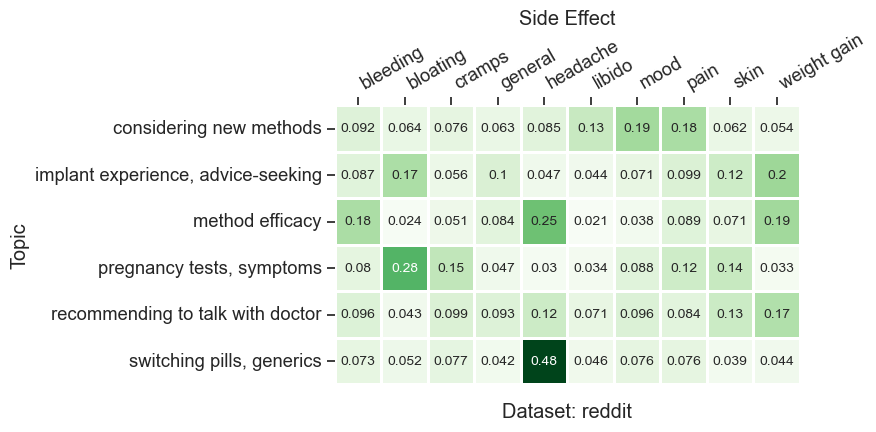

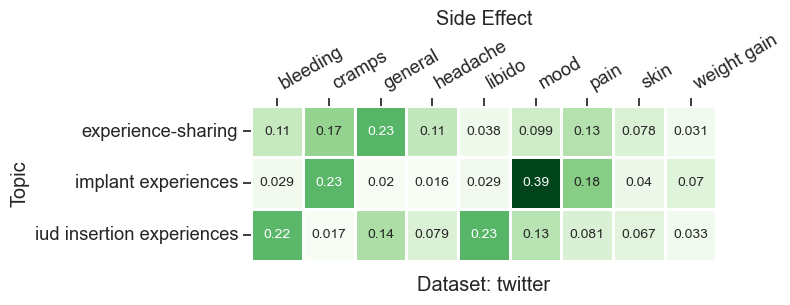

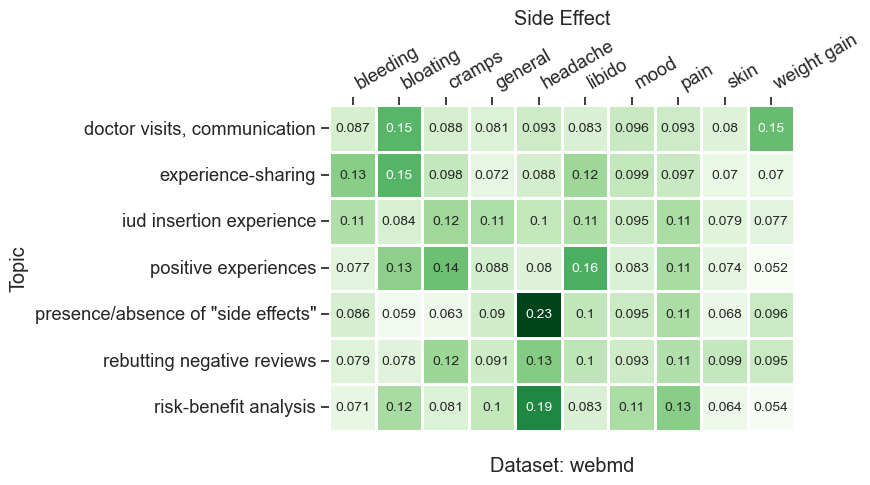

In [240]:
for _source, _side_effect_ids_dict in source_side_effect_ids_dict.items():

    dicts_to_plot = []
    for _side_effect, _ids in _side_effect_ids_dict.items():
        if _side_effect in ['bleeding', 'bloating', 'cramps', 'headache', 'libido', 'nauseua', 'skin', 'general', 'mood', 'pain', 'weight gain']:
            for _id in _ids:
                for _topic, _probability in enumerate(source_distributions_dict[_source][_id]):
                    if _topic in source_sensemaking_topics_dict_overlapping[_source]:
                        dicts_to_plot.append({'Side Effect': _side_effect,
                                              'Topic Index': _topic,
                                            #   'Topic': ' '.join(source_topic_keys_dict[_source][_topic][:5]),
                                              'Topic': source_string_dict[_source][_topic],
                                              'Probability': float(_probability),
                                              'Source': _source})
    df_to_plot = pd.DataFrame(dicts_to_plot)

    df_wide = df_to_plot.pivot_table(index='Topic', 
                                    columns='Side Effect', 
                                    values='Probability')
    df_norm_col = (df_wide-df_wide.mean())/df_wide.std()
    df_norm_row = df_wide.div(df_wide.sum(axis=1), axis=0)
        
    plt.figure(figsize=(6,5))
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_norm_row, 
                     cmap='Greens', 
                     cbar=False, 
                     linewidths=1, 
                     annot=True, 
                     fmt='0.2g', 
                     square=True, 
                     annot_kws={'fontsize':10})  
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    offset_distance=-0.15
    if _source == 'twitter':
        offset_distance = -0.25
    elif _source == 'webmd':
        offset_distance: 0.2
    plt.title('Dataset: ' + _source, y=offset_distance)
    plt.savefig(output_directory_path + '/plots/labeling/heatmap.topics_x_side_effects.percents.' + _source + '.pdf', bbox_inches='tight')
    plt.show()

In [ ]:
# for _source, _method_category_count_dict in source_method_category_count_dict.items():
#     for _method, _category_count_dict in _method_category_count_dict.items():
#         for _category, _count in _category_count_dict.items():
#             print(_source, '\t', _method, '\t', _count, '\t', round(source_method_category_percent_dict[_source][_method][_category], 2), '\t', _category)
#         print()
#     print()
#     print('------------------------------------------------------------')
#     print()

In [35]:
df_wide

Side Effect,bleeding,bloating,cramps,general,headache,libido,mood,pain,skin,weight gain
Topic,,,,,,,,,,
birth control months recommend also,0.037713,0.035594,0.038161,0.041725,0.040852,0.041117,0.042249,0.038987,0.041150,0.046737
cannot low dose gyn device,0.004744,0.005330,0.004856,0.005420,0.004313,0.003625,0.003249,0.005109,0.003957,0.004260
day take every one would,0.017923,0.015406,0.018411,0.016252,0.015753,0.016072,0.016053,0.017871,0.015334,0.016028
doctor would never said get,0.060490,0.059742,0.064934,0.061813,0.059965,0.057242,0.056777,0.066080,0.058303,0.060842
get take really love dont,0.026803,0.026738,0.028596,0.028432,0.023755,0.027040,0.026087,0.027286,0.026225,0.023763
like feel time get never,0.074478,0.105321,0.070875,0.077329,0.091439,0.086742,0.106035,0.076706,0.080331,0.092994
pain insertion cramping iud inserted,0.060114,0.044602,0.102670,0.038855,0.030842,0.030719,0.029845,0.076859,0.029942,0.026218
reviews read reading experience people,0.024300,0.025322,0.026842,0.022883,0.021086,0.021669,0.021149,0.024987,0.019463,0.019652
side effects effect headaches drug,0.025293,0.027274,0.021162,0.076799,0.037110,0.029877,0.028326,0.026108,0.026148,0.026213


In [13]:
df_to_plot.sample(10)

,Side Effect,Topic Index,Topic,Probability,Source
328581,nausea,1,pill NUM sex day took,5.538126456665074E-4,reddit
197168,mood,13,blood bleeding period spotting discharge,0.0015729280978413938,reddit
1304734,bleeding,4,infection yeast infections iud antibiotics,0.0013521017320782705,reddit
763294,pain,14,pain cramps like anyone else,7.91139354468062E-4,reddit
1165814,bleeding,34,NUM period periods months days,0.4343536513331459\n,reddit
772708,pain,13,blood bleeding period spotting discharge,0.0025987818130296003,reddit
43061,mood,11,insurance NUM planned parenthood get,8.79370814072538E-4,reddit
35016,mood,16,side effects effect nexplanon implant,0.0262408845585413,reddit
928877,bleeding,12,weight NUM gain gained pounds,6.591340773565279E-4,reddit
888183,pain,23,NUM pill taking tri switched,8.823502788255996E-4,reddit


In [32]:
df_to_plot['Source'].value_counts()

reddit    2349200
Name: Source, dtype: int64

<br><br><br><br>

# **Compare topics and labels**

In [183]:
label_df = pd.read_csv(data_directory_path + '/labeling/label-discourse/final.majority_labels.csv')
len(label_df.index)

750

In [184]:
def get_new_source(x):
    return x.split('-')[0]

label_df['Source-2'] = label_df['Source'].apply(get_new_source)
label_df.sample(3)

,Unnamed: 0,ID,Label,Text,Source,Decision,Source-2
384,384,559796711871483900,META DISCUSSION,Big debate: Is 10 years old too young to be gi...,twitter-posts,two or more,twitter
11,11,ccx1kg,SHARING PERSONAL EXPERIENCES,Suddenly I’m spotting and having moderate cramps.,reddit-posts,two or more,reddit
336,336,136420714638094340,SHARING INFORMATION,New Version of Contraceptive Implant Is Easier...,twitter-posts,two or more,twitter


In [185]:
label_df['Label'].value_counts()

SHARING PERSONAL EXPERIENCES                298
SHARING INFORMATION                          89
SHARING-DESCRIBING ADDITIONAL RESEARCH       67
META DISCUSSION                              65
SHARING OPINIONS AND PREFERENCES             62
SEEKING INFORMATION                          32
SHARING PERSONAL BACKGROUND                  25
SHARING FUTURE PLANS                         24
SEEKING EXPERIENCES                          22
SHARING ADVICE                               21
SHARING SECONDHAND EXPERIENCES               16
SEEKING EMOTIONAL SUPPORT                    11
SHARING CAUSAL REASONING - HYPOTHESIZING      7
SEEKING NORMALITY                             4
SEEKING ADVICE                                3
SHARING NORMALITY                             2
SHARING EMOTIONAL SUPPORT                     2
Name: Label, dtype: int64

In [186]:
source_labels_dict = {}
source_training_dict = {}

for _source in ['reddit', 'twitter', 'webmd']:

    path_to_mallet = '/Users/maria/Documents/packages/mallet-2.0.8/bin/mallet'
    path_to_training_data = '/Users/maria/Documents/output/birth-control/labeled_data_for_topic_modeling.' + _source
    path_to_formatted_training_data = '/Users/maria/Documents/output/birth-control/labeled_data_for_topic_modeling.mallet.' + _source
    path_to_new_topic_distributions = '/Users/maria/Documents/output/birth-control/labeled_data_for_topic_modeling.distributions.mallet.' + _source
    path_to_original_model = topics_directory_path + '/' + _source + '/mallet.model.35'

    source_training_dict[_source] = [lmw.process_string(str(r['Text'])) for i, r in label_df[label_df['Source-2'] == _source].iterrows() if lmw.process_string(str(r['Text'])).strip()]
    print(len(source_training_dict[_source] )) 

    source_labels_dict[_source] = label_df[label_df['Source-2'] == _source]['Label']
    print(len(source_labels_dict[_source]))

    lmw.import_data(path_to_mallet, path_to_training_data, path_to_formatted_training_data, source_training_dict[_source] , training_ids=None, use_pipe_from=None)

    lmw.infer_topics(path_to_mallet, path_to_original_model, path_to_formatted_training_data, path_to_new_topic_distributions)

258
258
Importing data...
Complete
Inferring topics using pre-trained model...
Complete
295
295
Importing data...
Complete
Inferring topics using pre-trained model...
Complete
197
197
Importing data...
Complete
Inferring topics using pre-trained model...
Complete


In [187]:
source_distributions_dict = {}

for _source in ['reddit', 'twitter', 'webmd']:

    source_distributions_dict[_source] = [_line.split('\t')[2:] for _line in open('/Users/maria/Documents/output/birth-control/labeled_data_for_topic_modeling.distributions.mallet.' + _source, 'r') if _line.strip()]
    source_distributions_dict[_source] = source_distributions_dict[_source][1:]

print(len(source_distributions_dict['reddit']), len(source_training_dict['reddit']))
print(len(source_distributions_dict['twitter']), len(source_training_dict['twitter']))
print(len(source_distributions_dict['webmd']), len(source_training_dict['webmd']))

258 258
295 295
197 197


In [188]:
for x in source_distributions_dict['webmd']:
    assert len(x) == 35

In [191]:
label_string_dict = {'SHARING PERSONAL EXPERIENCES': 'sharing experiences',
                        'SHARING INFORMATION': 'sharing info',
                        'SHARING-DESCRIBING ADDITIONAL RESEARCH': 'additional research',
                        'META DISCUSSION': 'meta discussion',
                        'SHARING OPINIONS AND PREFERENCES': 'opinions & preferences',
                        'SEEKING INFORMATION': 'seeking info',
                        'SHARING PERSONAL BACKGROUND': 'personal disclosures',
                        'SHARING FUTURE PLANS': 'future plans',
                        'SEEKING EXPERIENCES': 'seeking experiences',
                        'SHARING ADVICE': 'advice',
                        'SHARING SECONDHAND EXPERIENCES': 'secondhand experiences',
                        'SEEKING EMOTIONAL SUPPORT': 'seeking emotional support'}

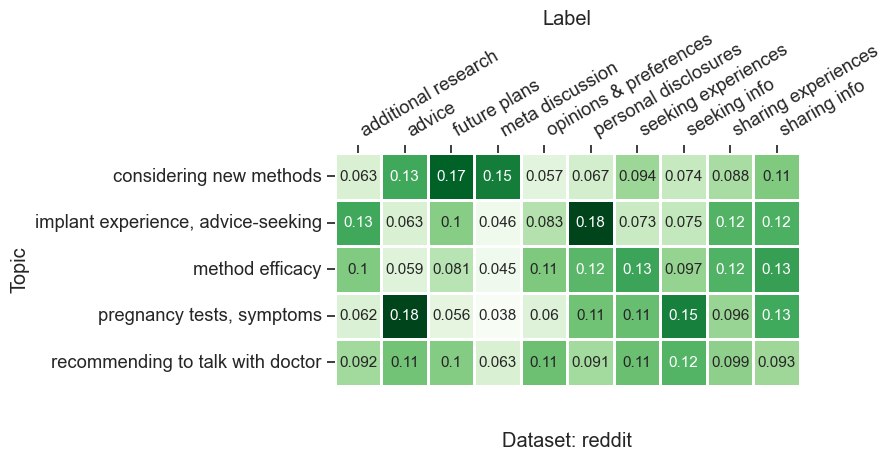

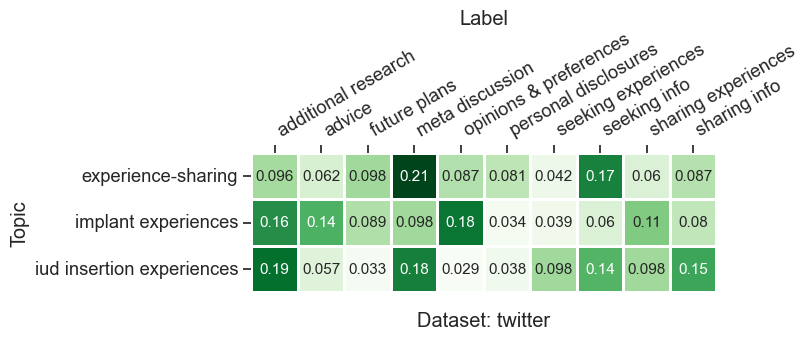

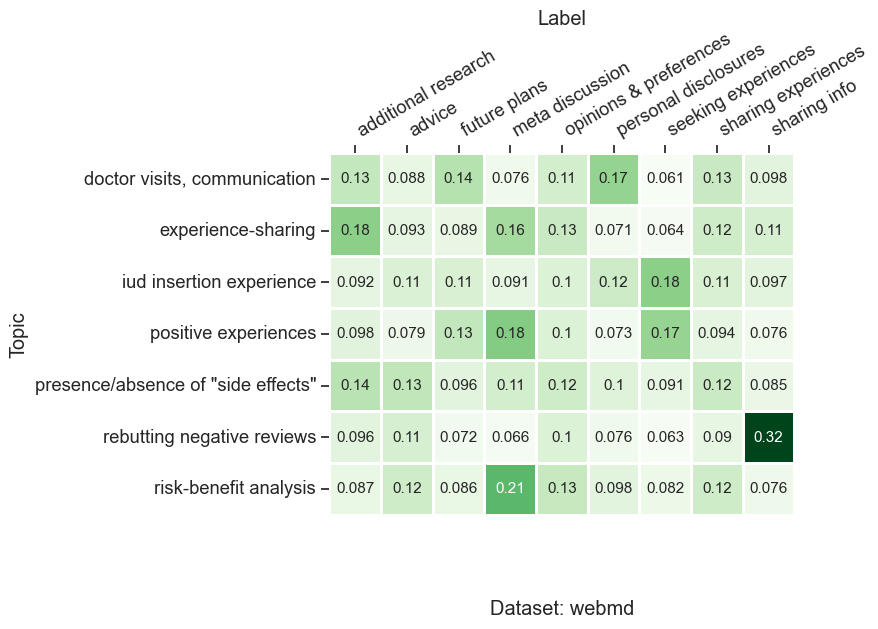

In [200]:
for _source, _labels in source_labels_dict.items():

    dicts_to_plot = []
    for i, _label in enumerate(_labels):
        if _label in ['SHARING PERSONAL EXPERIENCES',
                        'SHARING INFORMATION',
                        'SHARING-DESCRIBING ADDITIONAL RESEARCH',
                        'META DISCUSSION',
                        'SHARING OPINIONS AND PREFERENCES',
                        'SEEKING INFORMATION',
                        'SHARING PERSONAL BACKGROUND',
                        'SHARING FUTURE PLANS',
                        'SEEKING EXPERIENCES',
                        'SHARING ADVICE',
                        'SHARING SECONDHAND EXPERIENCES'
                        'SEEKING EMOTIONAL SUPPORT']:
                for _topic, _probability in enumerate(source_distributions_dict[_source][i]):
                    if _topic in source_sensemaking_topics_dict_overlapping[_source]:
                        dicts_to_plot.append({'Label': label_string_dict[_label].lower(),
                                              'Topic Index': _topic,
                                              'Topic': source_string_dict[_source][_topic],
                                              'Probability': float(_probability),
                                              'Source': _source})
    df_to_plot = pd.DataFrame(dicts_to_plot)

    df_wide = df_to_plot.pivot_table(index='Topic', 
                                    columns='Label', 
                                    values='Probability')
    df_norm_col = (df_wide-df_wide.mean())/df_wide.std()
    df_norm_row = df_wide.div(df_wide.sum(axis=1), axis=0)
        
    plt.figure(figsize=(6,8))
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_norm_row, 
                     cmap='Greens', 
                     cbar=False, 
                     linewidths=1, 
                     annot=True, 
                     fmt='0.2g', 
                     square=True, 
                     annot_kws={'fontsize':11})  
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    offset_distance=-0.15
    if _source == 'twitter':
        offset_distance = -0.25
    elif _source == 'webmd':
        offset_distance: 0.2
    plt.title('Dataset: ' + _source, y=offset_distance)
    plt.savefig(output_directory_path + '/plots/labeling/heatmap.topics_x_labels.percents.' + _source + '.pdf', bbox_inches='tight')
    plt.show()

In [198]:
# dicts_to_plot = []

# for _source, _labels in source_labels_dict.items():

    
#     for i, _label in enumerate(_labels):
#         if _label in ['SHARING PERSONAL EXPERIENCES',
#                         'SHARING INFORMATION',
#                         'SHARING-DESCRIBING ADDITIONAL RESEARCH',
#                         'META DISCUSSION',
#                         'SHARING OPINIONS AND PREFERENCES',
#                         'SEEKING INFORMATION',
#                         'SHARING PERSONAL BACKGROUND',
#                         'SHARING FUTURE PLANS',
#                         'SEEKING EXPERIENCES',
#                         'SHARING ADVICE',
#                         'SHARING SECONDHAND EXPERIENCES'
#                         'SEEKING EMOTIONAL SUPPORT']:
#                 for _topic, _probability in enumerate(source_distributions_dict[_source][i]):
#                     if _topic in source_sensemaking_topics_dict_overlapping[_source]:
#                         dicts_to_plot.append({'Label': label_string_dict[_label].lower(),
#                                               'Topic Index': _topic,
#                                               'Topic': source_string_dict[_source][_topic],
#                                               'Probability': float(_probability),
#                                               'Source': _source})
# df_to_plot = pd.DataFrame(dicts_to_plot)

# df_wide = df_to_plot.pivot_table(index='Topic', 
#                                 columns='Label', 
#                                 values='Probability')
# df_norm_col = (df_wide-df_wide.mean())/df_wide.std()
# df_norm_row = df_wide.div(df_wide.sum(axis=1), axis=0)
    
# plt.figure(figsize=(6,8))
# sns.set(style='ticks', font_scale=1.2)
# ax = sns.heatmap(df_norm_row, 
#                     cmap='Greens', 
#                     cbar=False, 
#                     linewidths=1, 
#                     annot=True, 
#                     fmt='0.2g', 
#                     square=True, 
#                     annot_kws={'fontsize':11})  
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')
# plt.xticks(rotation=30, ha='left')
# plt.title('Dataset: ' + _source, y=-0.2)
# plt.savefig(output_directory_path + '/plots/labeling/heatmap.topics_x_labels.percents.' + _source + '.pdf', bbox_inches='tight')
# plt.show()

In [149]:
df_to_plot.sample(10)

,Label,Topic Index,Topic,Probability,Source
1631,sharing opinions and preferences,5,positive experiences,0.052677,webmd
375,sharing future plans,18,experience-sharing,0.025519,webmd
1580,sharing personal experiences,0,rebutting negative reviews,0.019437,webmd
531,sharing personal experiences,5,positive experiences,0.098767,webmd
188,sharing personal experiences,24,"presence/absence of ""side effects""",0.016490,webmd
611,sharing personal experiences,5,positive experiences,0.061694,webmd
733,sharing personal background,16,risk-benefit analysis,0.001962,webmd
61,sharing personal experiences,5,positive experiences,0.017741,webmd
1260,sharing-describing additional research,0,rebutting negative reviews,0.023263,webmd
131,sharing opinions and preferences,5,positive experiences,0.020606,webmd


In [178]:
dicts_to_plot = []
for i, _label in enumerate(_labels):
        if _label in ['SHARING PERSONAL EXPERIENCES',
                        'SHARING INFORMATION',
                        'SHARING-DESCRIBING ADDITIONAL RESEARCH',
                        'META DISCUSSION',
                        'SHARING OPINIONS AND PREFERENCES',
                        'SEEKING INFORMATION',
                        'SHARING PERSONAL BACKGROUND',
                        'SHARING FUTURE PLANS',
                        'SEEKING EXPERIENCES',
                        'SHARING ADVICE',
                        'SHARING SECONDHAND EXPERIENCES'
                        'SEEKING EMOTIONAL SUPPORT']:
                for _topic, _probability in enumerate(source_distributions_dict['twitter'][i]):
                        if _topic in source_sensemaking_topics_dict['twitter']:
                                dicts_to_plot.append({'Label': _label.lower(),
                                                'ID': i,
                                                'Topic Index': _topic,
                                                'Topic': source_string_dict['twitter'][_topic],
                                                'Probability': float(_probability),
                                                'Source': 'twitter'})
df_to_plot = pd.DataFrame(dicts_to_plot)
    
for i, r in df_to_plot[(df_to_plot['Label'] == 'sharing personal experiences') & (df_to_plot['Topic'] == 'contraceptive studies') & (df_to_plot['Source'] == 'twitter')].sort_values('Probability', ascending=False).head(20).iterrows():

        print(round(r['Probability'], 3))
        print(source_training_dict['twitter'][r['ID']])

0.394
come oral contraception yaz commercial women cutting hair
0.323
given birth twice nobody ever offered abort delivering
0.184
whispers silent thank iud https //t co/hwrkayqvNUM
0.178
gonna bruise honestly least worries whole nexplanon ordeal https //t co/bmnNUMhaNUMdne
0.126
bayer halves price contraceptive implant jadelle women developing countries https //t co/jyefeotqtg pharma biotech
0.118
bayer halves price contraceptive implant jadelle women developing countries https //t co/jyefeotqtg pharma biotech
0.091
like iud cramps worst omg
0.086
thank lord jesus getting implant nexplanon removed tomorrow
0.083
cant wait get implanon shit outta arm
0.074
invention birth control pill changed sex game women
0.064
one warned night sweats got implanon
0.049
helll nahhhhhh one hormones shit horrible
0.046
iud goes arm right
0.042
nexplanon thinned uterus extent bleeding everyday NUM months said looked like menopausal woman uterus lol
0.041
sciencedaily waiting game immediate birth control

In [171]:
df_to_plot['Topic'].value_counts()

rebutting negative reviews            192
positive experiences                  192
switching pills, generic              192
risk-benefit analysis                 192
iud insertion experience              192
experience-sharing                    192
life interferences                    192
doctor visits, communication          192
presence/absence of "side effects"    192
experience-sharing pt 2               192
Name: Topic, dtype: int64

<br><br><br><br>

# **Compare topics and methods**

Can't easily do this, the topics data doesn't have the original IDs and I can't completely extract the methods like the side effects (for webmd and twitter, the methods also come from the query)

In [ ]:
for _source, _side_effect_ids_dict in source_side_effect_ids_dict.items():

    dicts_to_plot = []
    for     
        for _topic, _probability in enumerate(source_distributions_dict[_source][_id]):
            if _topic in source_sensemaking_topics_dict[_source]:
                dicts_to_plot.append({'Side Effect': _side_effect,
                                        'Topic Index': _topic,
                                    #   'Topic': ' '.join(source_topic_keys_dict[_source][_topic][:5]),
                                        'Topic': source_string_dict[_source][_topic],
                                        'Probability': float(_probability),
                                        'Source': _source})
    df_to_plot = pd.DataFrame(dicts_to_plot)

    df_wide = df_to_plot.pivot_table(index='Topic', 
                                    columns='Side Effect', 
                                    values='Probability')
    df_norm_col = (df_wide-df_wide.mean())/df_wide.std()
    df_norm_row = df_wide.div(df_wide.sum(axis=1), axis=0)
        
    plt.figure(figsize=(8,10))
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_norm_row, 
                     cmap='Greens', 
                     cbar=False, 
                     linewidths=1, 
                     annot=True, 
                     fmt='0.2g', 
                     square=True, 
                     annot_kws={'fontsize':10})  
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    # plt.savefig(output_directory_path + '/plots/labeling/heatmap.topics_x_side_effects.percents.pdf', bbox_inches='tight')
    plt.show()